# Chessboard Vision Project  

## 📌 Introduction  
This project is part of the **Computer Vision** course in the Master's in Artificial Intelligence. The goal is to detect chess pieces on a board from images, determine their positions using bounding boxes, and represent them in an 8x8 matrix format. The solution is implemented in Python and follows a structured image processing pipeline.

## 🎯 Task Overview  
- **Input:** Chessboard image  
- **Output:**  
  - Total number of black/white pieces  
  - Bounding boxes around detected pieces  
  - 8x8 matrix representing piece positions  
- **Dataset:** 50 images for development, 10 unseen test images  
- **Deliverables:**  
  - Python script (single file)  
  - Short report (max 2 pages) 

---

## Importing Required Libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math

# Data Directory
dataDir = 'images'

# Define the window size
window_width = 800
window_height = 600

In [2]:
# Function to resize image
def resize_image(image, window_width, window_height):
    height, width = image.shape[:2]
    scaling_factor = min(window_width / width, window_height / height)
    return cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

## Chessboard Detection

In [3]:
def detect_and_extract_chessboard(image_path, display=True):
    """
    Detect and extract a chessboard from an image with perspective correction.
    
    Parameters:
        image_path: Path to the input image
        display: Whether to display results
        
    Returns:
        Warped (perspective-corrected) chessboard image, or None if detection fails
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None
    
    # Convert to grayscale and blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Sobel filters
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobelx = cv2.convertScaleAbs(sobelx)
    abs_sobely = cv2.convertScaleAbs(sobely)
    
    # Try different Sobel weights to find the best contour
    weights = [(0.5, 0.5), (0.7, 0.7), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]
    chessboard_contour = None
    
    # Find chessboard contour
    for wx, wy in weights:
        sobel_combined = cv2.addWeighted(abs_sobelx, wx, abs_sobely, wy, 0)
        _, thresh_sobel = cv2.threshold(sobel_combined, 50, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_sobel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_img = img.copy()
            
        # Sort by area, get largest
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:25]
            
        for contour in contours:
            peri = cv2.arcLength(contour, True)
            for approx_param in [0.01, 0.02, 0.03, 0.04, 0.05]:
                approx = cv2.approxPolyDP(contour, approx_param * peri, True)
                
                # Check if it's a quadrilateral with appropriate area
                if len(approx) == 4 and cv2.contourArea(approx) > (img.shape[0] * img.shape[1]) * 0.15:
                    chessboard_contour = approx
                    print(f"Found chessboard in {os.path.basename(image_path)} with weights ({wx}, {wy}), approx {approx_param}")
                    break
            if chessboard_contour is not None:
                break
            
        if chessboard_contour is not None:
            break
    
    if chessboard_contour is None:
        print(f"No chessboard contour found in {os.path.basename(image_path)}")
        return None
    
    # Process the chessboard
    cv2.drawContours(contour_img, [chessboard_contour], -1, (0, 255, 0), 3)
    
    # Perspective transform
    rect = np.zeros((4, 2), dtype="float32")
    pts = chessboard_contour.reshape(4, 2)
    
    # Sort corners - top to bottom
    y_sorted = pts[np.argsort(pts[:, 1]), :] 
    top_two = y_sorted[:2]
    bottom_two = y_sorted[2:]
    
    # Sort left to right
    top_left = top_two[np.argmin(top_two[:, 0])]
    top_right = top_two[np.argmax(top_two[:, 0])]
    bottom_left = bottom_two[np.argmin(bottom_two[:, 0])]
    bottom_right = bottom_two[np.argmax(bottom_two[:, 0])]
    
    # Assign corners
    rect[0] = top_left
    rect[1] = top_right
    rect[2] = bottom_right
    rect[3] = bottom_left
    
    # Calculate dimensions
    width_top = np.sqrt(((rect[0][0] - rect[1][0])**2) + ((rect[0][1] - rect[1][1])**2))
    width_bottom = np.sqrt(((rect[2][0] - rect[3][0])**2) + ((rect[2][1] - rect[3][1])**2))
    width = int(max(width_top, width_bottom))
    
    height_left = np.sqrt(((rect[0][0] - rect[3][0])**2) + ((rect[0][1] - rect[3][1])**2))
    height_right = np.sqrt(((rect[1][0] - rect[2][0])**2) + ((rect[1][1] - rect[2][1])**2))
    height = int(max(height_left, height_right))
    
    # Force square if dimensions are close
    if abs(width - height) < min(width, height) * 0.2:
        size = max(width, height)
        width, height = size, size
    
    # Check minimum size
    if width < 200 or height < 200:
        print(f"Warning: Small transform size in {os.path.basename(image_path)} ({width}x{height})")
        if min(width, height) < 50:
            print(f"Transform too small for {os.path.basename(image_path)}, skipping")
            return None
    
    # Define destination points
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    
    # Apply transform
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (width, height))
    
    # Check if transform failed
    if np.all(warped == warped[0, 0]):
        print(f"Error: Uniform color in warped image for {os.path.basename(image_path)}")
        
        # Try fallback method
        print(f"Trying fallback corner detection for {os.path.basename(image_path)}")
        
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(img, M, (width, height))
        
        if np.all(warped == warped[0, 0]):
            print(f"Fallback also failed for {os.path.basename(image_path)}")
            return None
        else:
            print(f"Fallback succeeded for {os.path.basename(image_path)}")
    
    # Display results if requested
    if display:
        resized_contour_img = resize_image(contour_img, window_width, window_height)
        resized_warped = resize_image(warped, window_width, window_height)
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(resized_contour_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected: {os.path.basename(image_path)}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(resized_warped, cv2.COLOR_BGR2RGB))
        plt.title("Perspective Transformed")
        plt.axis('off')
        plt.show()
    
    return warped

In [4]:
def batch_process_chessboards(directory, specific_image=None, max_display=5):
    """
    Process chess images in a directory or a specific chess image.
    """
    results = {}
    display_count = 0

    if specific_image:
        # Process a single image
        print(f"Processing single image: {os.path.basename(specific_image)}")
        display = display_count < max_display
        warped = detect_and_extract_chessboard(specific_image, display)
        success = warped is not None
        results[os.path.basename(specific_image)] = success

        if success and display:
            display_count += 1
    else:
        # Process all images in the directory
        image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
        print(f"Processing {len(image_files)} images...")

        for image_file in image_files:
            image_path = os.path.join(directory, image_file)
            display = display_count < max_display

            warped = detect_and_extract_chessboard(image_path, display)
            success = warped is not None
            results[image_file] = success

            if success and display:
                display_count += 1

    # Print summary
    success_count = sum(results.values())
    total_images = len(results)
    print(f"\nSummary: Successfully processed {success_count} out of {total_images} images ({success_count / total_images * 100:.1f}%)")

    # List failed images
    failed_images = [img for img, success in results.items() if not success]
    if failed_images:
        print("\nFailed images:")
        for img in failed_images:
            print(f"- {img}")

    return results

Processing single image: G000_IMG062.jpg
Found chessboard in G000_IMG062.jpg with weights (0.5, 0.5), approx 0.02


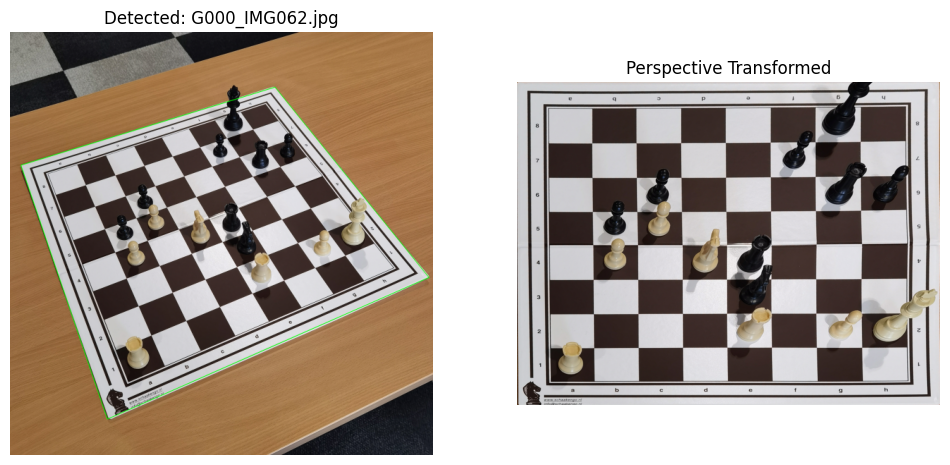


Summary: Successfully processed 1 out of 1 images (100.0%)


In [5]:
# Process all images in the directory
#results_all = batch_process_chessboards(dataDir, max_display=50)

# Process a specific image
results_single = batch_process_chessboards(dataDir, specific_image=os.path.join(dataDir, 'G000_IMG062.jpg'))

## Chess Piece Detection

In [6]:
def detect_chess_piece_color_mask(image_path, display_intermediate=True):
    """
    Process image and detect both black and white chess pieces at once.
    
    Parameters:
        image_path: Path to the input image
        display_intermediate: Whether to display intermediate results
        
    Returns:
        Tuple of (warped image, black mask, white mask)
    """
    # Process image to get warped chessboard
    warped = detect_and_extract_chessboard(image_path, display=False)
    
    if warped is None:
        print(f"Failed to get the warped image for {os.path.basename(image_path)}")
        return None, None, None
    
    blurred = cv2.GaussianBlur(warped, (5, 5), 0)

    # Convert to HSV for color detection
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    
    # Create masks for both colors at once
    # Black pieces - dark with low saturation
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 60, 30])
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    
    # White pieces
    white_lower = np.array([15, 30, 135])
    white_upper = np.array([35, 135, 225])
    white_mask = cv2.inRange(hsv, white_lower, white_upper)
    
    # Apply morphological operations to clean up the masks
    kernel_open = np.ones((3, 3), np.uint8)
    kernel_close = np.ones((7, 7), np.uint8)
    
    # Process black mask
    black_mask = cv2.morphologyEx(black_mask, cv2.MORPH_CLOSE, kernel_close)
    black_mask = cv2.morphologyEx(black_mask, cv2.MORPH_OPEN, kernel_open)
    
    # Process white mask
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel_close)
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel_open)
    
    # Apply masks to original image
    black_result = cv2.bitwise_and(blurred, blurred, mask=black_mask)
    white_result = cv2.bitwise_and(blurred, blurred, mask=white_mask)
    
    # Display results if requested
    if display_intermediate:
        # Show masks side by side
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        plt.title("Original Warped Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(black_mask, cmap='gray')
        plt.title("Black Pieces Mask")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(white_mask, cmap='gray')
        plt.title("White Pieces Mask")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        # Show masked results
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(black_result, cv2.COLOR_BGR2RGB))
        plt.title("Black Pieces")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(white_result, cv2.COLOR_BGR2RGB))
        plt.title("White Pieces")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        # Create a combined image with both black and white piece bounding boxes
        contour_img = warped.copy()
        black_count = 0
        white_count = 0
        
        # Process black contours
        black_contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in black_contours:
            area = cv2.contourArea(contour)
            if area >= 4500:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h if h > 0 else 0
                if 0.25 <= aspect_ratio <= 2.0:
                    black_count += 1
                    cv2.rectangle(contour_img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Process white contours
        white_contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in white_contours:
            area = cv2.contourArea(contour)
            if area >= 4500:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h if h > 0 else 0
                if 0.25 <= aspect_ratio <= 2.0:
                    white_count += 1
                    cv2.rectangle(contour_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Pieces: {black_count} Black, {white_count} White")
        plt.axis("off")
        plt.show()
    
    return warped, black_mask, white_mask

In [7]:
def process_chess_piece_masks(directory, image_path=None, max_display=5):
    """
    Process chess piece masks for a single image or all images in a directory.
    """
    results = {}
    display_count = 0

    if image_path:
        # Process a single image
        print(f"Processing single image: {os.path.basename(image_path)}")
        display = display_count < max_display
        warped, black_mask, white_mask = detect_chess_piece_color_mask(image_path, display_intermediate=display)
        results[os.path.basename(image_path)] = (warped, black_mask, white_mask)
    else:
        # Process all images in the directory
        image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
        print(f"Processing {len(image_files)} images...")

        for image_file in image_files:
            image_path = os.path.join(directory, image_file)
            display = display_count < max_display

            warped, black_mask, white_mask = detect_chess_piece_color_mask(image_path, display_intermediate=display)
            results[image_file] = (warped, black_mask, white_mask)

            if warped is not None and display:
                display_count += 1

    # Print summary
    success_count = sum(1 for result in results.values() if result[0] is not None)
    total_images = len(results)
    print(f"\nSummary: Successfully processed {success_count} out of {total_images} images ({success_count / total_images * 100:.1f}%)")

    # List failed images
    failed_images = [img for img, result in results.items() if result[0] is None]
    if failed_images:
        print("\nFailed images:")
        for img in failed_images:
            print(f"- {img}")

    return results

Processing single image: G000_IMG062.jpg
Found chessboard in G000_IMG062.jpg with weights (0.5, 0.5), approx 0.02


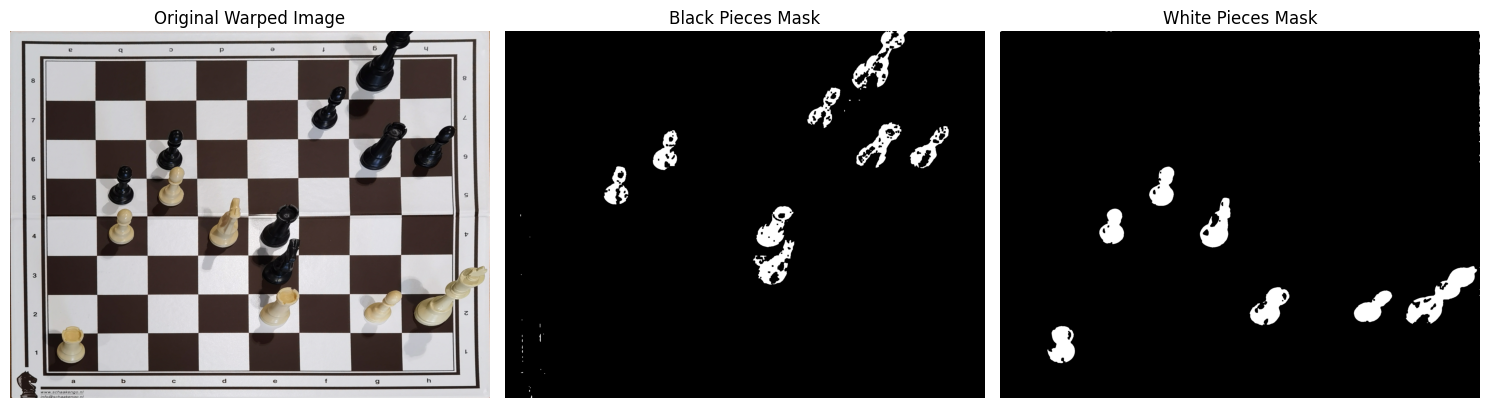

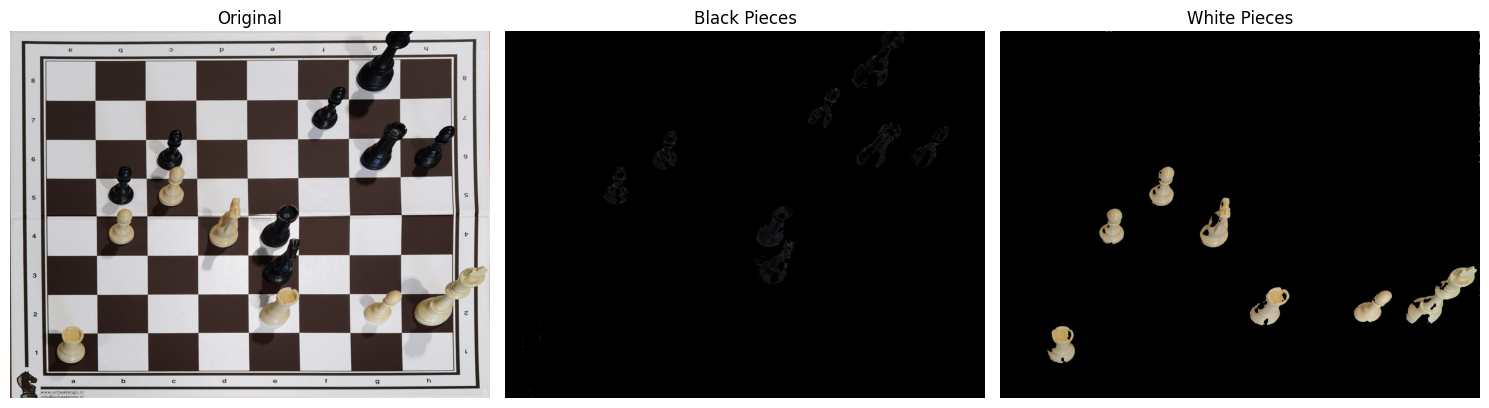

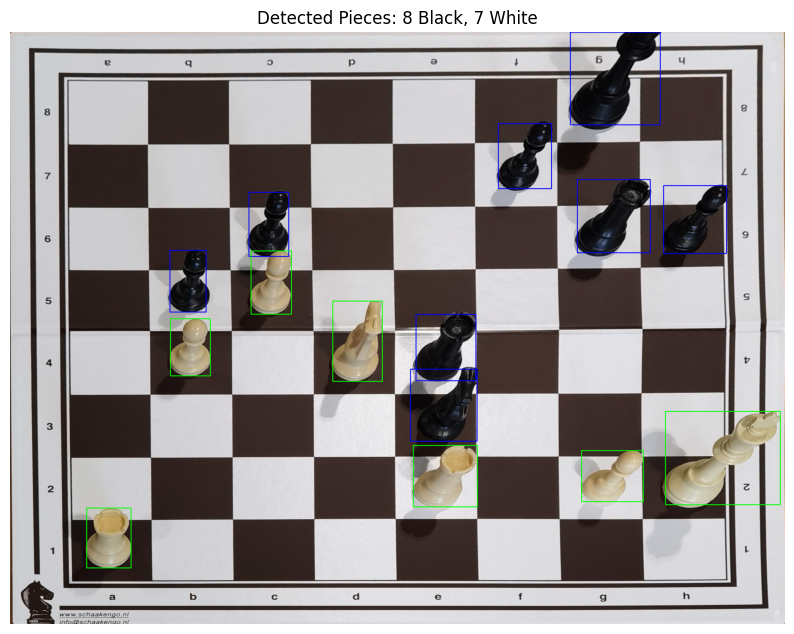


Summary: Successfully processed 1 out of 1 images (100.0%)


In [8]:
# Process all images in the directory
#results_all = process_chess_piece_masks(dataDir, max_display=5)

# Process a specific image
results_single = process_chess_piece_masks(dataDir, image_path=os.path.join(dataDir, 'G000_IMG062.jpg'))

## Chessboard Grid Visualization

In [9]:
def draw_grid(image, h_margin=20, v_margin=20, line_color=(0, 255, 0), line_thickness=2):
    """
    Draws a grid with 9 vertical and 9 horizontal lines on the given chessboard image,
    using separate margins for horizontal (left/right) and vertical (top/bottom) edges.
    
    Parameters:
        image: Input chessboard image as a NumPy array.
        h_margin: Horizontal margin (applied on left/right sides) for vertical lines.
        v_margin: Vertical margin (applied on top/bottom) for horizontal lines.
        line_color: Color of the grid lines.
        line_thickness: Thickness of the grid lines.
    
    Returns:
        A new image with the grid drawn.
    """
    grid_img = image.copy()
    height, width = grid_img.shape[:2]

    # Calculate spacing using separate margins
    x_spacing = (width - 2 * h_margin) / 8
    y_spacing = (height - 2 * v_margin) / 8

    # Draw vertical lines using horizontal margin
    for i in range(9):
        x = int(h_margin + i * x_spacing)
        pt1 = (x, v_margin)
        pt2 = (x, height - v_margin)
        cv2.line(grid_img, pt1, pt2, line_color, line_thickness)

    # Draw horizontal lines using vertical margin
    for i in range(9):
        y = int(v_margin + i * y_spacing)
        pt1 = (h_margin, y)
        pt2 = (width - h_margin, y)
        cv2.line(grid_img, pt1, pt2, line_color, line_thickness)

    return grid_img

In [10]:
def process_draw_grid(directory, image_path=None, h_margin=20, v_margin=20, max_display=5):
    """
    Process and draw a grid on a single image or all images in a directory.
    """
    results = {}
    display_count = 0

    if image_path:
        # Process a single image
        print(f"Processing single image: {os.path.basename(image_path)}")
        warped = detect_and_extract_chessboard(image_path, display=False)
        if warped is not None:
            grid_image = draw_grid(warped, h_margin, v_margin)
            plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
            plt.title(f"Grid on {os.path.basename(image_path)}")
            plt.axis("off")
            plt.show()
            results[os.path.basename(image_path)] = True
        else:
            print(f"Failed to process {os.path.basename(image_path)}")
            results[os.path.basename(image_path)] = False
    else:
        # Process all images in the directory
        image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
        print(f"Processing {len(image_files)} images...")

        for image_file in image_files:
            image_path = os.path.join(directory, image_file)
            display = display_count < max_display

            warped = detect_and_extract_chessboard(image_path, display=False)
            if warped is not None:
                grid_image = draw_grid(warped, h_margin, v_margin)
                if display:
                    plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
                    plt.title(f"Grid on {image_file}")
                    plt.axis("off")
                    plt.show()
                    display_count += 1
                results[image_file] = True
            else:
                print(f"Failed to process {image_file}")
                results[image_file] = False

    # Print summary
    success_count = sum(results.values())
    total_images = len(results)
    print(f"\nSummary: Successfully processed {success_count} out of {total_images} images ({success_count / total_images * 100:.1f}%)")

    # List failed images
    failed_images = [img for img, success in results.items() if not success]
    if failed_images:
        print("\nFailed images:")
        for img in failed_images:
            print(f"- {img}")

    return results

Processing single image: G000_IMG062.jpg
Found chessboard in G000_IMG062.jpg with weights (0.5, 0.5), approx 0.02


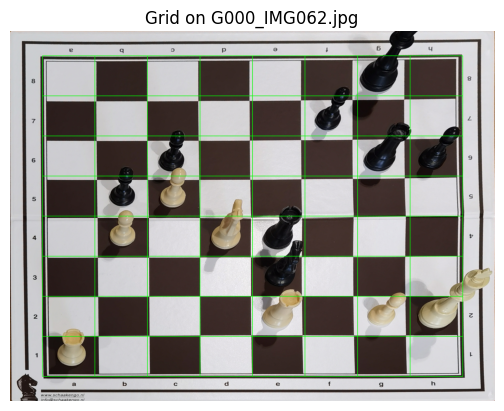


Summary: Successfully processed 1 out of 1 images (100.0%)


In [11]:
# Process all images in the directory
#results_all = process_draw_grid(dataDir, h_margin=170, v_margin=130, max_display=5)

# Process a specific image
results_single = process_draw_grid(dataDir, image_path=os.path.join(dataDir, 'G000_IMG062.jpg'), h_margin=170, v_margin=130)

## Chessboard Matrix Generation

In [12]:
def create_chessboard_matrix(warped_image, black_mask, white_mask, h_margin=170, v_margin=130, display=True):
    """
    Creates an 8x8 matrix representing the chessboard state (0=empty, 1=piece).
    Uses bottom-left corner of bounding boxes with margin as reference point.
    
    Parameters:
        warped_image: Perspective-corrected chessboard image
        black_mask: Binary mask for black pieces
        white_mask: Binary mask for white pieces
        h_margin: Horizontal margin for grid
        v_margin: Vertical margin for grid
        display: Whether to show visualization
        
    Returns:
        8x8 numpy array (0=empty, 1=piece present)
    """
    height, width = warped_image.shape[:2]
    
    # Calculate grid cell dimensions
    cell_width = (width - 2 * h_margin) / 8
    cell_height = (height - 2 * v_margin) / 8
    
    # Initialize the chessboard matrix
    board_matrix = np.zeros((8, 8), dtype=int)
    
    # Create visualization image
    if display:
        vis_image = warped_image.copy()
        # Draw the grid
        grid_image = draw_grid(vis_image, h_margin, v_margin, line_color=(255, 0, 255), line_thickness=1)
    
    # Function to determine which cell a point belongs to
    def get_cell_position(x, y):
        if (x < h_margin or x >= width - h_margin or 
            y < v_margin or y >= height - v_margin):
            return None  # Outside the chessboard grid
        
        col = int((x - h_margin) // cell_width)
        row = int((y - v_margin) // cell_height)
        
        # Ensure we're within bounds (due to rounding)
        if 0 <= row < 8 and 0 <= col < 8:
            return (row, col)
        else:
            return None
    
    # Distance from corner to use as reference point
    corner_margin = 10  # Pixels from corner
    
    # Process black and white pieces
    for mask, color in [(black_mask, (255, 0, 0)), (white_mask, (0, 255, 0))]:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area >= 4500:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h if h > 0 else 0
                if 0.25 <= aspect_ratio <= 2.0:
                    # Define reference point (bottom-left corner + margin)
                    ref_x = x + corner_margin
                    ref_y = y + h - corner_margin
                    
                    cell = get_cell_position(ref_x, ref_y)
                    if cell:
                        row, col = cell
                        board_matrix[row][col] = 1
                        
                    # For visualization
                    if display:
                        # Draw bounding box
                        cv2.rectangle(grid_image, (x, y), (x + w, y + h), color, 2)
                        # Draw the reference point
                        cv2.circle(grid_image, (ref_x, ref_y), 5, (0, 0, 255), -1)
    
    # Display the result
    if display:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
        plt.title("Chessboard State Detection")
        plt.axis("off")
        plt.show()
        
        # Print matrix for verification
        print("Chessboard Matrix (1 = piece, 0 = empty):")
        print(np.array2string(board_matrix))
    
    return board_matrix

In [13]:
def process_chessboard_matrices(directory, image_path=None, h_margin=170, v_margin=130, max_display=5):
    """
    Process and create chessboard matrices for a single image or all images in a directory.
    """
    results = {}
    display_count = 0

    if image_path:
        # Process a single image
        print(f"Processing single image: {os.path.basename(image_path)}")
        warped, black_mask, white_mask = detect_chess_piece_color_mask(image_path, display_intermediate=False)
        if warped is not None:
            board_matrix = create_chessboard_matrix(warped, black_mask, white_mask, h_margin, v_margin, display=display_count < max_display)
            results[os.path.basename(image_path)] = board_matrix
        else:
            print(f"Failed to process {os.path.basename(image_path)}")
            results[os.path.basename(image_path)] = None
    else:
        # Process all images in the directory
        image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
        print(f"Processing {len(image_files)} images...")

        for image_file in image_files:
            image_path = os.path.join(directory, image_file)
            display = display_count < max_display

            warped, black_mask, white_mask = detect_chess_piece_color_mask(image_path, display_intermediate=False)
            if warped is not None:
                board_matrix = create_chessboard_matrix(warped, black_mask, white_mask, h_margin, v_margin, display=display)
                results[image_file] = board_matrix
                if display:
                    display_count += 1
            else:
                print(f"Failed to process {image_file}")
                results[image_file] = None

    # Print summary
    success_count = sum(1 for result in results.values() if result is not None)
    total_images = len(results)
    print(f"\nSummary: Successfully processed {success_count} out of {total_images} images ({success_count / total_images * 100:.1f}%)")

    # List failed images
    failed_images = [img for img, result in results.items() if result is None]
    if failed_images:
        print("\nFailed images:")
        for img in failed_images:
            print(f"- {img}")

    return results

Processing single image: G000_IMG062.jpg
Found chessboard in G000_IMG062.jpg with weights (0.5, 0.5), approx 0.02


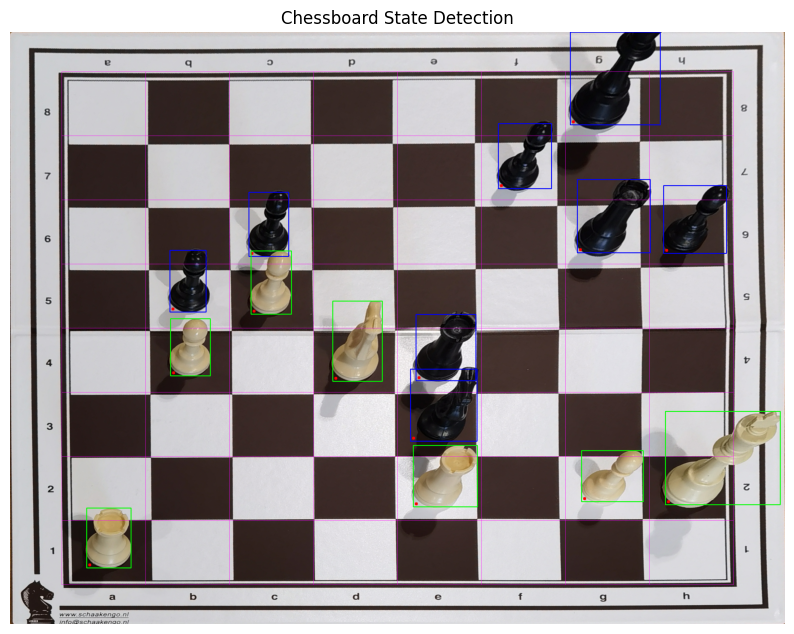

Chessboard Matrix (1 = piece, 0 = empty):
[[0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 1 1]
 [0 1 1 0 0 0 0 0]
 [0 1 0 1 1 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 1]
 [1 0 0 0 0 0 0 0]]

Summary: Successfully processed 1 out of 1 images (100.0%)


In [14]:
# Process all images in the directory
#results_all = process_chessboard_matrices(dataDir, h_margin=170, v_margin=130, max_display=5)

# Process a specific image
results_single = process_chessboard_matrices(dataDir, image_path=os.path.join(dataDir, 'G000_IMG062.jpg'), h_margin=170, v_margin=130)

## Mapping to Original Coordinates

In [15]:
def map_warped_to_original_coords(contour, image_path, black_mask, white_mask, display=True):
    """
    Maps chess piece coordinates from the warped image back to the original image.
    
    Parameters:
        image_path: Path to the original image
        black_mask: Binary mask for black pieces in warped image
        white_mask: Binary mask for white pieces in warped image
        display: Whether to display visualization
        
    Returns:
        Dictionary with piece coordinates in the original image
    """
    # Load original image
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Failed to load image: {image_path}")
        return None
    
    # Get the transformation matrix by running the detection process again
    # (We need to access the same matrix that was used for warping)
    img_copy = original_img.copy()
    
    # Convert to grayscale and blur
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Sobel filters
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobelx = cv2.convertScaleAbs(sobelx)
    abs_sobely = cv2.convertScaleAbs(sobely)
    
    # Find chessboard contour
    weights = [(0.5, 0.5), (0.7, 0.7), (1.0, 1.0), (1.5, 1.5), (2.0, 2.0)]
    chessboard_contour = None
    transform_matrix = None
    
    # Find chessboard contour using same approach as detect_and_extract_chessboard()
    for wx, wy in weights:
        sobel_combined = cv2.addWeighted(abs_sobelx, wx, abs_sobely, wy, 0)
        _, thresh_sobel = cv2.threshold(sobel_combined, 50, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_sobel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sort by area, get largest
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:25]
        
        for contour in contours:
            peri = cv2.arcLength(contour, True)
            for approx_param in [0.01, 0.02, 0.03, 0.04, 0.05]:
                approx = cv2.approxPolyDP(contour, approx_param * peri, True)
                
                # Check if it's a quadrilateral with appropriate area
                if len(approx) == 4 and cv2.contourArea(approx) > (img_copy.shape[0] * img_copy.shape[1]) * 0.15:
                    chessboard_contour = approx
                    break
            if chessboard_contour is not None:
                break
        if chessboard_contour is not None:
            break
    
    if chessboard_contour is None:
        print(f"No chessboard contour found in {os.path.basename(image_path)}")
        return None
    
    # Get the perspective transform matrix (same as in detect_and_extract_chessboard)
    rect = np.zeros((4, 2), dtype="float32")
    pts = chessboard_contour.reshape(4, 2)
    
    # Sort corners - top to bottom
    y_sorted = pts[np.argsort(pts[:, 1]), :] 
    top_two = y_sorted[:2]
    bottom_two = y_sorted[2:]
    
    # Sort left to right
    top_left = top_two[np.argmin(top_two[:, 0])]
    top_right = top_two[np.argmax(top_two[:, 0])]
    bottom_left = bottom_two[np.argmin(bottom_two[:, 0])]
    bottom_right = bottom_two[np.argmax(bottom_two[:, 0])]
    
    # Assign corners
    rect[0] = top_left
    rect[1] = top_right
    rect[2] = bottom_right
    rect[3] = bottom_left
    
    # Calculate dimensions
    width_top = np.sqrt(((rect[0][0] - rect[1][0])**2) + ((rect[0][1] - rect[1][1])**2))
    width_bottom = np.sqrt(((rect[2][0] - rect[3][0])**2) + ((rect[2][1] - rect[3][1])**2))
    width = int(max(width_top, width_bottom))
    
    height_left = np.sqrt(((rect[0][0] - rect[3][0])**2) + ((rect[0][1] - rect[3][1])**2))
    height_right = np.sqrt(((rect[1][0] - rect[2][0])**2) + ((rect[1][1] - rect[2][1])**2))
    height = int(max(height_left, height_right))
    
    if abs(width - height) < min(width, height) * 0.2:
        size = max(width, height)
        width, height = size, size
    
    # Define destination points
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    
    # Get the forward transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    
    # Get the inverse transform matrix
    M_inv = cv2.getPerspectiveTransform(dst, rect)
    
    # Process black and white pieces to get original coordinates
    piece_coords = []
    
    # Results dictionary
    results = {
        "pieces": []
    }
    
    # Create visualization image if requested
    if display:
        vis_img = original_img.copy()
    
    # Process black and white pieces
    for mask, color_name, color in [(black_mask, "black", (255, 0, 0)), (white_mask, "white", (0, 255, 0))]:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area >= 4500:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w) / h if h > 0 else 0
                if 0.25 <= aspect_ratio <= 2.0:
                    # Define the four corners of the bounding box in the warped image
                    warped_corners = np.array([
                        [x, y],
                        [x + w, y],
                        [x + w, y + h],
                        [x, y + h]
                    ], dtype=np.float32)
                    
                    # Reshape for perspective transform
                    warped_corners = warped_corners.reshape(-1, 1, 2)
                    
                    # Apply inverse perspective transform to get coordinates in original image
                    original_corners = cv2.perspectiveTransform(warped_corners, M_inv)
                    original_corners = original_corners.reshape(4, 2)
                    
                    # Calculate the bounding box in original image
                    x_values = original_corners[:, 0]
                    y_values = original_corners[:, 1]
                    xmin, ymin = int(min(x_values)), int(min(y_values))
                    xmax, ymax = int(max(x_values)), int(max(y_values))
                    
                    # Add to results
                    results["pieces"].append({
                        "color": color_name,
                        "xmin": xmin,
                        "ymin": ymin,
                        "xmax": xmax,
                        "ymax": ymax
                    })
                    
                    # Draw on visualization image if requested
                    if display:
                        cv2.rectangle(vis_img, (xmin, ymin), (xmax, ymax), color, 2)
    
    # Display visualization if requested
    if display:
        plt.figure(figsize=(12, 10))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title("Chess Piece Coordinates in Original Image")
        plt.axis("off")
        plt.show()
        
        # Print piece coordinates
        print(f"Found {len(results['pieces'])} pieces:")
        for i, piece in enumerate(results["pieces"]):
            print(f"Piece {i+1} ({piece['color']}): xmin={piece['xmin']}, ymin={piece['ymin']}, xmax={piece['xmax']}, ymax={piece['ymax']}")
    
    return results

In [16]:
def process_mapped_coordinates(directory, image_path=None, max_display=5):
    """
    Process and map chess piece coordinates from warped images back to the original images
    for a single image or all images in a directory.

    Parameters:
        directory (str): Path to the directory containing images.
        image_path (str, optional): Path to a specific image to process. If None, processes all images in the directory.
        max_display (int): Maximum number of images to display during processing.

    Returns:
        dict: A dictionary with image filenames as keys and mapped coordinates as values.
    """
    results = {}
    display_count = 0

    if image_path:
        # Process a single image
        print(f"Processing single image: {os.path.basename(image_path)}")
        warped, black_mask, white_mask = detect_chess_piece_color_mask(image_path, display_intermediate=False)
        if warped is not None:
            mapped_coords = map_warped_to_original_coords(warped, image_path, black_mask, white_mask, display=display_count < max_display)
            results[os.path.basename(image_path)] = mapped_coords
        else:
            print(f"Failed to process {os.path.basename(image_path)}")
            results[os.path.basename(image_path)] = None
    else:
        # Process all images in the directory
        image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
        print(f"Processing {len(image_files)} images...")

        for image_file in image_files:
            image_path = os.path.join(directory, image_file)
            display = display_count < max_display

            warped, black_mask, white_mask = detect_chess_piece_color_mask(image_path, display_intermediate=False)
            if warped is not None:
                mapped_coords = map_warped_to_original_coords(warped, image_path, black_mask, white_mask, display=display)
                results[image_file] = mapped_coords
                if display:
                    display_count += 1
            else:
                print(f"Failed to process {image_file}")
                results[image_file] = None

    # Print summary
    success_count = sum(1 for result in results.values() if result is not None)
    total_images = len(results)
    print(f"\nSummary: Successfully processed {success_count} out of {total_images} images ({success_count / total_images * 100:.1f}%)")

    # List failed images
    failed_images = [img for img, result in results.items() if result is None]
    if failed_images:
        print("\nFailed images:")
        for img in failed_images:
            print(f"- {img}")

    return results

Processing single image: G000_IMG062.jpg
Found chessboard in G000_IMG062.jpg with weights (0.5, 0.5), approx 0.02


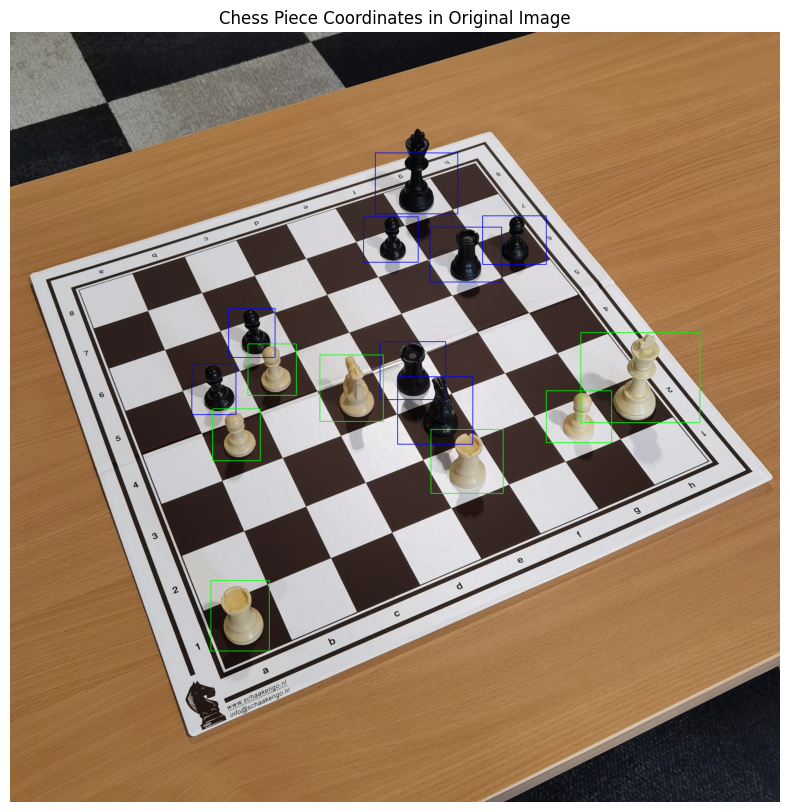

Found 15 pieces:
Piece 1 (black): xmin=1546, ymin=1375, xmax=1846, ymax=1644
Piece 2 (black): xmin=1476, ymin=1235, xmax=1738, ymax=1466
Piece 3 (black): xmin=725, ymin=1323, xmax=901, ymax=1526
Piece 4 (black): xmin=872, ymin=1102, xmax=1057, ymax=1298
Piece 5 (black): xmin=1885, ymin=733, xmax=2139, ymax=927
Piece 6 (black): xmin=1675, ymin=778, xmax=1961, ymax=997
Piece 7 (black): xmin=1410, ymin=737, xmax=1628, ymax=918
Piece 8 (black): xmin=1457, ymin=482, xmax=1786, ymax=725
Piece 9 (white): xmin=801, ymin=2188, xmax=1034, ymax=2469
Piece 10 (white): xmin=2139, ymin=1431, xmax=2400, ymax=1638
Piece 11 (white): xmin=1679, ymin=1585, xmax=1967, ymax=1840
Piece 12 (white): xmin=2277, ymin=1199, xmax=2752, ymax=1558
Piece 13 (white): xmin=808, ymin=1503, xmax=998, ymax=1710
Piece 14 (white): xmin=1236, ymin=1288, xmax=1489, ymax=1553
Piece 15 (white): xmin=949, ymin=1244, xmax=1142, ymax=1449

Summary: Successfully processed 1 out of 1 images (100.0%)


In [17]:
# Process all images in the directory
#results_all = process_mapped_coordinates(dataDir, max_display=5)

# Process a specific image
results_single = process_mapped_coordinates(dataDir, image_path=os.path.join(dataDir, 'G000_IMG062.jpg'))